In [2]:
import json
with open('results.json', 'r') as fp:
    res = json.load(fp)
data = []
for entry in res:
    data += entry['data']['users']

## Fetch Gho Users

In [3]:
from utils.gho_filter import filter_gho_users

In [4]:
# only use case is minting so far?
histories = ['borrowHistory']

gho_users = filter_gho_users(data, histories)
print(len(gho_users))

2297


This is quite a bit more than the number of mints reported on this Dune dashboard:
https://dune.com/consideredfinance/gho

The dashboard filters not by borrow events but simply by looking at Transfer events from the ERC20 contract where the from field is the zero address. 

We'll reproduce this with a subgraph to get a list of the concerned transactions and cross-check with what we get from the official AAVE subgraph. The subgraph code is available at: https://github.com/benber86/gho_token_subgraph

### Get all mints by parsing transfers from address zero on GHO subgraph

This requires pulling data with `pull_transfers.py` and using a public version of the subgraph.

In [5]:
import json
with open('transfer_results.json', 'r') as fp:
    tx_data = json.load(fp)

In [6]:
len(tx_data)

82094

In [7]:
transfer_mints = set([tx['transactionHash'] for tx in tx_data if tx['from'] == '0x0000000000000000000000000000000000000000'])

In [11]:
len(transfer_mints - mint_transactions)

181

The difference is just from new queries, so no issues with the subgraph, it's just the DUNE dashboard being stale or misreporting

## Get all GHO borrow transactions

In [9]:
def get_gho_usage(history: dict, action: str) -> bool:
    for action in history[action]:
        if 'reserve' in action:
            if action['reserve']['symbol'] == 'GHO':
                return True
    return False
    
transactions = []
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            transactions += [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
print(len(transactions))

6684


In [10]:
user_transactions = {}
first_transactions = {}
full_transactions = {}
mint_transactions = set()
for history in histories:
    for entry in data:
        if get_gho_usage(entry, history):
            user_gho_transactions = [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
            user_transactions[entry['id']] = len(user_gho_transactions)
            mint_transactions |= set(user_gho_transactions)
            first_transaction = min([c['timestamp'] for c in entry[history] if c['reserve']['symbol'] == 'GHO'])
            first_transactions[entry['id']] = first_transaction
            full_transactions[entry['id']] = [c for c in entry[history] if c['reserve']['symbol'] == 'GHO']

### Cumulative new GHO users

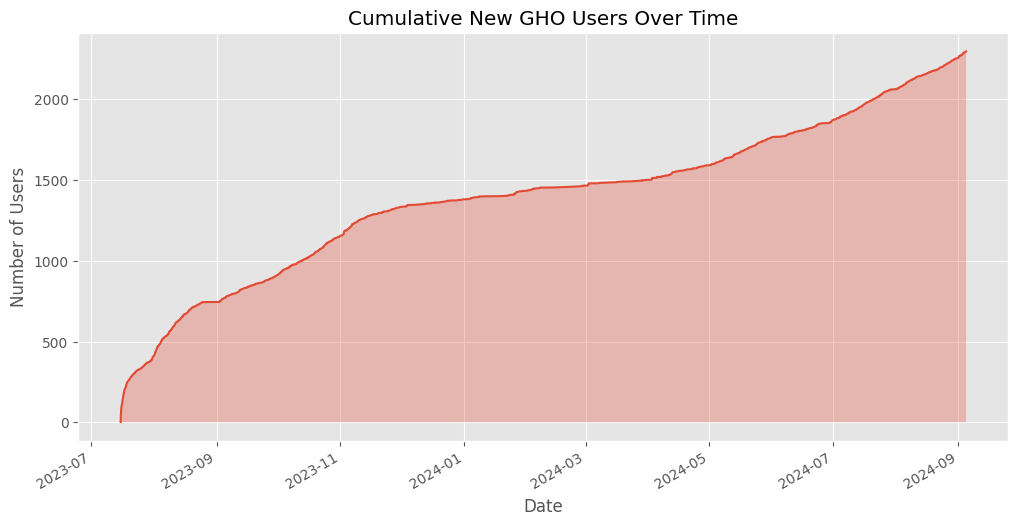

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

plt.style.use('ggplot')
df = pd.DataFrame.from_dict(first_transactions, orient='index', columns=['timestamp'])
df.index.name = 'user'
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.sort_values('timestamp')
df['cumulative_users'] = range(1, len(df) + 1)


plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['cumulative_users'])
plt.fill_between(df['timestamp'], df['cumulative_users'], alpha=0.3)
plt.title('Cumulative New GHO Users Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.grid(True)

# Improve x-axis readability
plt.gcf().autofmt_xdate()

# Show the plot
plt.show()

In [159]:
cumulative_json_data = df.copy().set_index(df['timestamp'].astype(int) // int(1e9))['cumulative_users'].to_dict()
with open('cumulative_users.json', 'w') as f:
    json.dump(cumulative_json_data, f)

### Growth rate of new users

Top growth periods:
Period ending 2023-08-04: 35.54% growth over 7 days
Period ending 2023-08-11: 18.16% growth over 7 days
Period ending 2023-08-22: 8.32% growth over 7 days
Period ending 2023-11-07: 6.48% growth over 7 days
Period ending 2023-10-03: 6.07% growth over 7 days


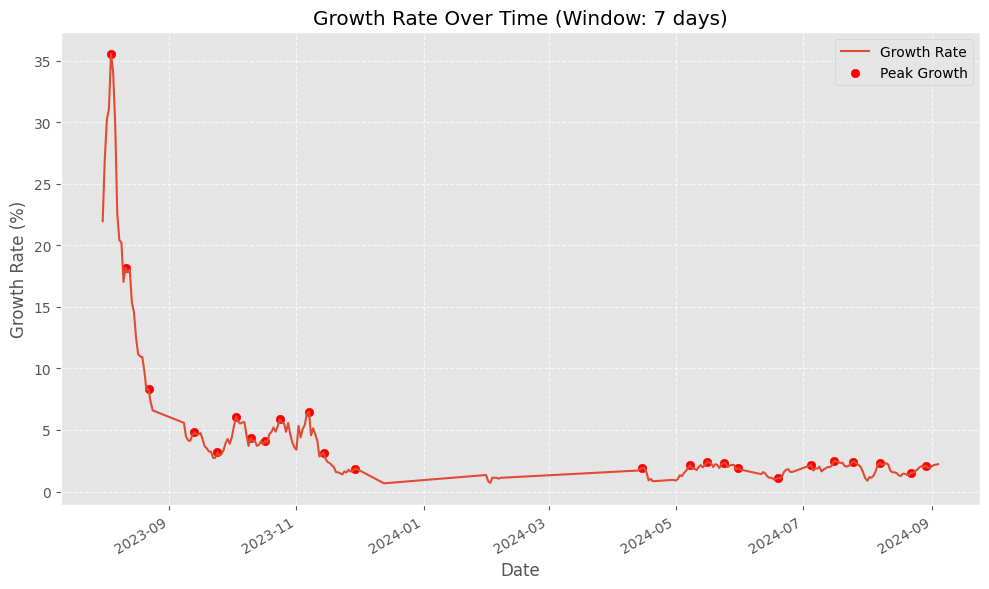

In [13]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

df_daily = df.resample('D', on='timestamp').last().reset_index()
df_daily['daily_change'] = df_daily['cumulative_users'].diff()

def calculate_growth_rate(data):
    return (data.iloc[-1] - data.iloc[0]) / data.iloc[0] * 100 if data.iloc[0] > 0 else 0

window_size = 7
df_daily['growth_rate'] = df_daily['cumulative_users'].rolling(window=window_size).apply(calculate_growth_rate)

df_daily = df_daily.dropna()[10:]

peaks, _ = find_peaks(df_daily['growth_rate'], distance=window_size)

top_n = 5
top_growth_periods = df_daily.iloc[peaks].sort_values('growth_rate', ascending=False).head(top_n)

print("Top growth periods:")
for _, row in top_growth_periods.iterrows():
    print(f"Period ending {row['timestamp'].date()}: {row['growth_rate']:.2f}% growth over {window_size} days")

plt.figure(figsize=(10, 6))
plt.plot(df_daily['timestamp'], df_daily['growth_rate'], label='Growth Rate')
plt.scatter(df_daily.iloc[peaks]['timestamp'], df_daily.iloc[peaks]['growth_rate'], color='red', label='Peak Growth')
plt.title(f'Growth Rate Over Time (Window: {window_size} days)')
plt.xlabel('Date')
plt.ylabel('Growth Rate (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

### Relationship with debt cap

The protracted low growth period Q1 2024 just as the market was expanding and the subsequent period marked by lots of small peaks suggests that the cap was the primary obstacle to adoption. Let's check this by looking at its history.

In [14]:
tx_df = pd.DataFrame(tx_data)
tx_df['borrowCap'] = tx_df['borrowCap'].astype(float)
tx_df['totalVariableDebt'] = tx_df['totalVariableDebt'].astype(float)
tx_df['utilization'] = tx_df.apply(lambda row: row['totalVariableDebt'] // 1e18 / row['borrowCap'] * 100 if row['borrowCap'] > 0 else 0, axis=1)

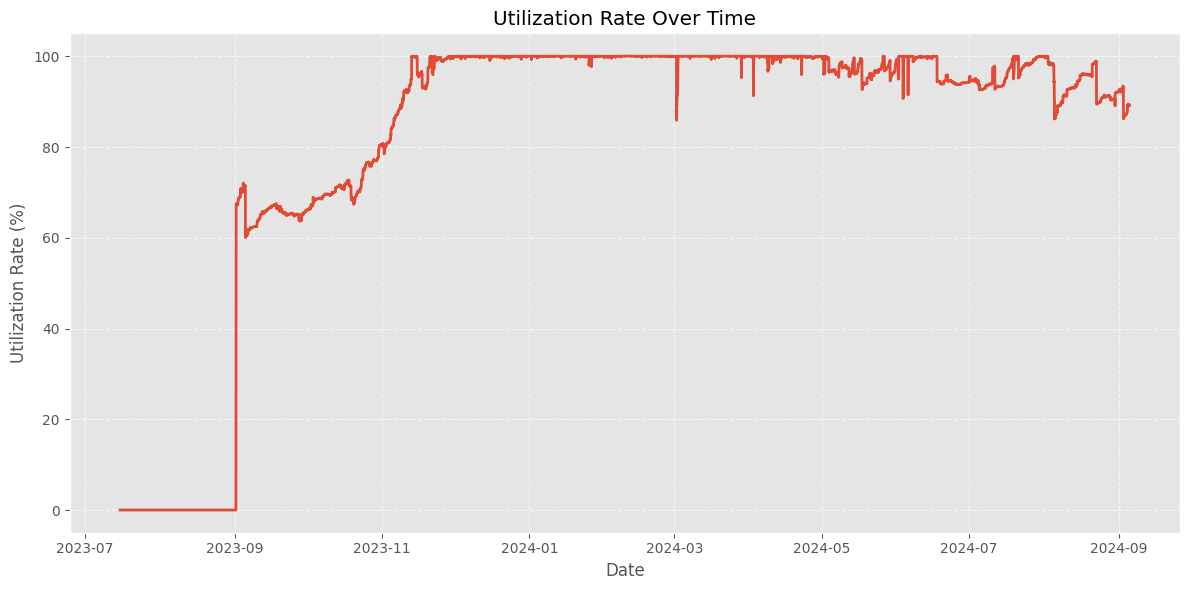

In [18]:
tx_df['datetime'] = pd.to_datetime(tx_df['blockTimestamp'], unit='s')

plt.figure(figsize=(12, 6))
plt.plot(tx_df['datetime'], tx_df['utilization'], linewidth=2)
plt.title('Utilization Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Utilization Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

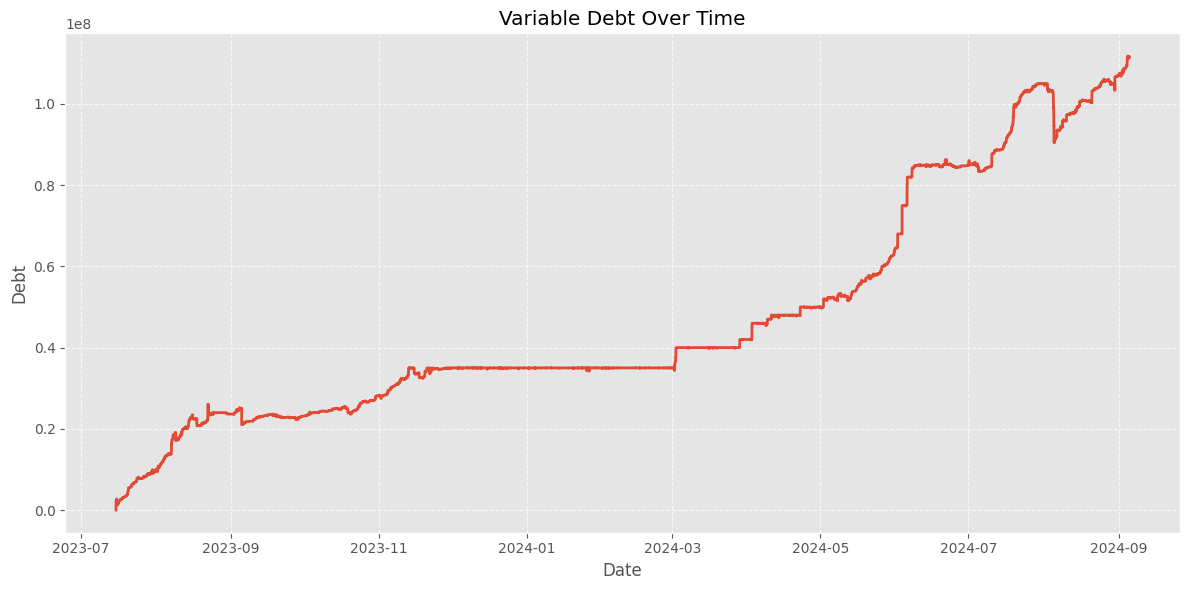

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(tx_df['datetime'], tx_df['totalVariableDebt'] * 1e-18, linewidth=2)
plt.title('Variable Debt Over Time')
plt.xlabel('Date')
plt.ylabel('Debt')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
debt_df = tx_df.copy()[['blockTimestamp', 'totalVariableDebt']]
DAY = 60 * 60 * 24
debt_df['blockTimestamp'] = debt_df['blockTimestamp'].astype(int) // DAY * DAY
debt_df = debt_df.drop_duplicates('blockTimestamp')
debt_data = (debt_df.set_index(debt_df['blockTimestamp'])['totalVariableDebt'] // int(1e18)).to_dict()
with open('debt_time_series.json', 'w') as f:
    json.dump(debt_data, f)

Now let's plot the two together

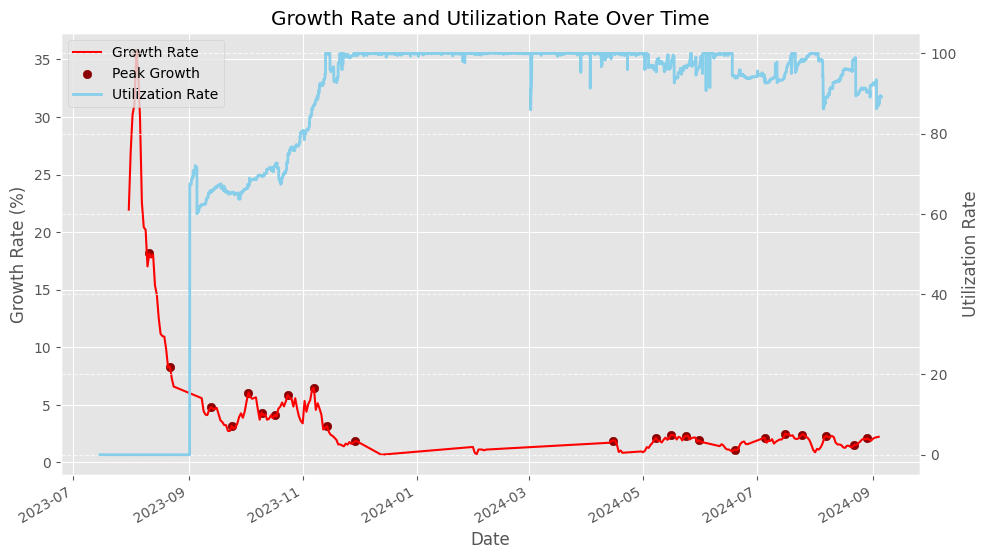

In [28]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Growth Rate (%)')
ax1.plot(df_daily['timestamp'], df_daily['growth_rate'], color=color1, label='Growth Rate')
ax1.scatter(df_daily.iloc[peaks]['timestamp'], df_daily.iloc[peaks]['growth_rate'], color='darkred', label='Peak Growth')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
color2 = 'skyblue'
ax2.set_ylabel('Utilization Rate')
ax2.plot(tx_df['datetime'], tx_df['utilization'], color=color2, linewidth=2, label='Utilization Rate')
ax2.tick_params(axis='y')

plt.title('Growth Rate and Utilization Rate Over Time')
fig.tight_layout()

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.7)
plt.gcf().autofmt_xdate()
plt.show()

In [29]:
chart_data = {
    'growth_rate': {
        'x': df_daily['timestamp'].dt.strftime('%Y-%m-%d').tolist(),
        'y': df_daily['growth_rate'].tolist()
    },
    'utilization_rate': {
        'x': tx_df['datetime'].dt.strftime('%Y-%m-%d').tolist(),
        'y': tx_df['utilization'].tolist()
    },
    'peak_growth': {
        'x': df_daily.iloc[peaks]['timestamp'].dt.strftime('%Y-%m-%d').tolist(),
        'y': df_daily.iloc[peaks]['growth_rate'].tolist()
    }
}

with open('growth_cap_chart_data.json', 'w') as f:
    json.dump(chart_data, f)


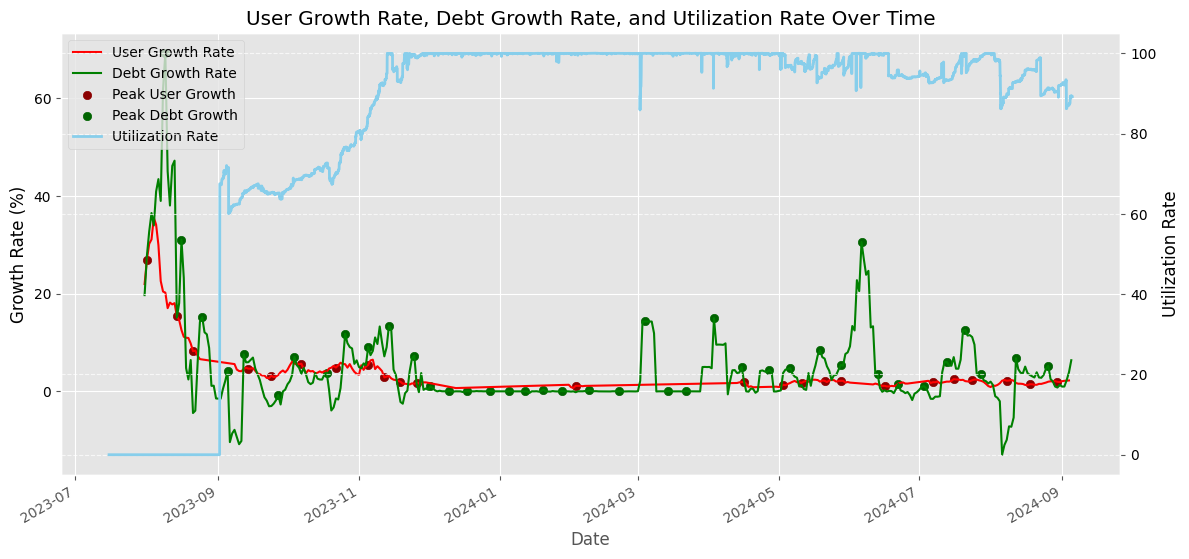

In [34]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Convert blockTimestamp to datetime
debt_df['datetime'] = pd.to_datetime(debt_df['blockTimestamp'], unit='s')
debt_df = debt_df.set_index('datetime')

# Resample to daily frequency and calculate daily change
debt_df_daily = debt_df.resample('D').last().reset_index()
debt_df_daily['daily_change'] = debt_df_daily['totalVariableDebt'].diff()

# Calculate growth rate for debt
window_size = 7
debt_df_daily['debt_growth_rate'] = debt_df_daily['totalVariableDebt'].rolling(window=window_size).apply(calculate_growth_rate)

# Remove NaN values and first few entries
debt_df_daily = debt_df_daily.dropna()[10:]

# Find peaks in debt growth rate
debt_peaks, _ = find_peaks(debt_df_daily['debt_growth_rate'], distance=window_size)

# Plot all three metrics
fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'red'
color2 = 'green'
color3 = 'skyblue'

ax1.set_xlabel('Date')
ax1.set_ylabel('Growth Rate (%)', color='black')
ax1.plot(df_daily['timestamp'], df_daily['growth_rate'], color=color1, label='User Growth Rate')
ax1.plot(debt_df_daily['datetime'], debt_df_daily['debt_growth_rate'], color=color2, label='Debt Growth Rate')
ax1.scatter(df_daily.iloc[peaks]['timestamp'], df_daily.iloc[peaks]['growth_rate'], color='darkred', label='Peak User Growth')
ax1.scatter(debt_df_daily.iloc[debt_peaks]['datetime'], debt_df_daily.iloc[debt_peaks]['debt_growth_rate'], color='darkgreen', label='Peak Debt Growth')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.set_ylabel('Utilization Rate', color='black')
ax2.plot(tx_df['datetime'], tx_df['utilization'], color=color3, linewidth=2, label='Utilization Rate')
ax2.tick_params(axis='y', labelcolor='black')

plt.title('User Growth Rate, Debt Growth Rate, and Utilization Rate Over Time')
fig.tight_layout()

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.7)
plt.gcf().autofmt_xdate()
plt.show()

In [37]:
import json
from datetime import datetime

user_growth_data = df_daily[['timestamp', 'growth_rate']].dropna().to_dict('records')
user_growth_data = [{'timestamp': int(row['timestamp'].timestamp()), 'value': row['growth_rate']} for row in user_growth_data]

debt_growth_data = debt_df_daily[['datetime', 'debt_growth_rate']].dropna().to_dict('records')
debt_growth_data = [{'timestamp': int(row['datetime'].timestamp()), 'value': row['debt_growth_rate']} for row in debt_growth_data]

DAY = 60 * 60 * 24
tx_df['day_timestamp'] = tx_df['blockTimestamp'].astype(int) // DAY * DAY
utilization_df = tx_df.groupby('day_timestamp')['utilization'].last().reset_index()
utilization_data = [{'timestamp': int(row['day_timestamp']), 'value': row['utilization']} for row in utilization_df.to_dict('records')]

export_data = {
    'user_growth_rate': user_growth_data,
    'debt_growth_rate': debt_growth_data,
    'utilization_rate': utilization_data
}

with open('growth_and_utilization_data.json', 'w') as f:
    json.dump(export_data, f, indent=2)

#### Number of days needed to fill cap

In [41]:
tx_df[tx_df['datetime'] > date_to_timestamp("2024-09-01")]

0        False
1        False
2        False
3        False
4        False
         ...  
82090     True
82089     True
82091     True
82092     True
82093     True
Name: datetime, Length: 82094, dtype: bool

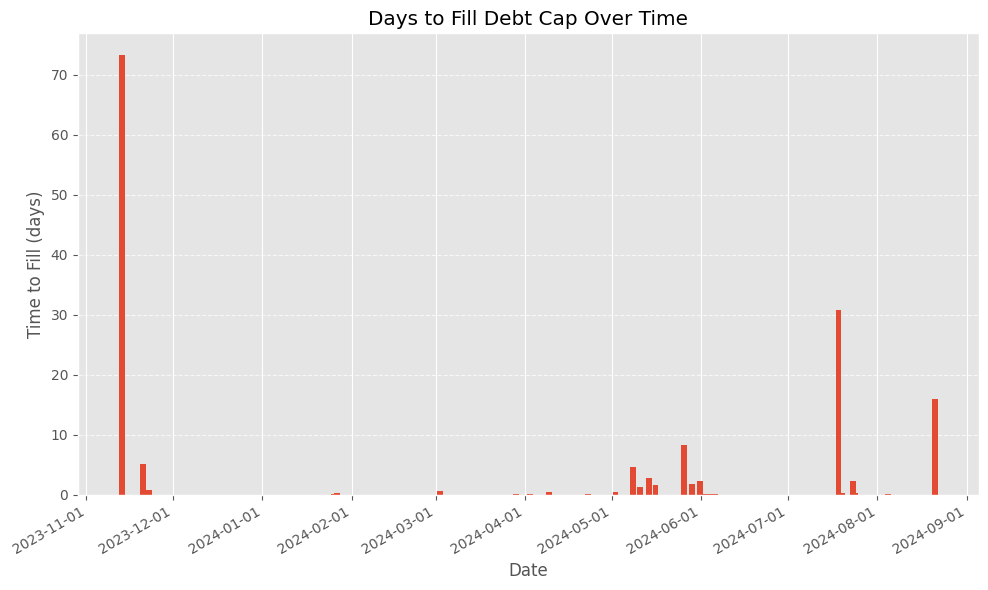

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def date_to_timestamp(date_string):
    return datetime.strptime(date_string, "%Y-%m-%d")


tx_df['datetime'] = pd.to_datetime(tx_df['datetime'])
cap_df = tx_df[tx_df['datetime'] > date_to_timestamp("2023-09-01")]

def calculate_fill_times(df):
    fill_times = []
    start_time = None
    for _, row in df.iterrows():
        if row['utilization'] < 98 and start_time is None:
            start_time = row['datetime']
        elif row['utilization'] >= 98 and start_time is not None:
            duration = (row['datetime'] - start_time).total_seconds() / 86400
            fill_times.append((row['datetime'], duration))
            start_time = None
    return pd.DataFrame(fill_times, columns=['datetime', 'fill_time'])

fill_times_df = calculate_fill_times(cap_df)

plt.figure(figsize=(10, 6))
plt.bar(fill_times_df['datetime'], fill_times_df['fill_time'], width=2, align='center')
plt.xlabel('Date')
plt.ylabel('Time to Fill (days)')
plt.title('Days to Fill Debt Cap Over Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [48]:
fill_times_df['timestamp'] = fill_times_df['datetime'].astype(int) // 10**9
fill_times_df = fill_times_df.drop('datetime', axis=1)

json_data = fill_times_df.to_dict(orient='records')

with open('fill_times_data.json', 'w') as f:
    json.dump(json_data, f, indent=2)

### Number of GHO mints per user

In [106]:
import pandas as pd

In [107]:
df_txs = pd.DataFrame.from_dict(user_transactions, orient='index').reset_index()
df_txs.columns = ['user', 'count']

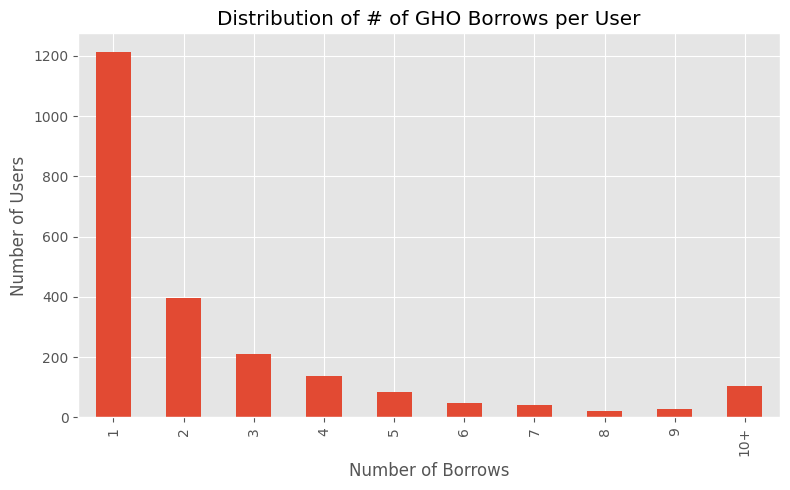

In [125]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

df_txs['count'] = np.where(df_txs['count'] > 10, 10, df_txs['count'])
counts = df_txs['count'].value_counts().sort_index()
counts = counts.rename(index={10: '10+'})

fig, ax = plt.subplots(figsize=(8, 5))
counts.plot(kind='bar', ax=ax)

ax.set_xlabel('Number of Borrows')
ax.set_ylabel('Number of Users')
ax.set_title('Distribution of # of GHO Borrows per User')

plt.tight_layout()
plt.show()

In [102]:
r = [_ for _ in data if _['id'] == '0xd14f076044414c255d2e82cceb1cb00fb1bba64c']
print(len(r[0]['borrowHistory']))
[_ for _ in r[0]['borrowHistory'] if _['txHash'] == '0xc3e464da5d13be568bbb076d291a0758d203ca22ecc011736c70bd8691c90573']

165


[{'action': 'Borrow',
  'amount': '100000000000000000000000',
  'assetPriceUSD': '0',
  'borrowRate': '15000000000000000000000000',
  'borrowRateMode': 2,
  'caller': {'id': '0xd14f076044414c255d2e82cceb1cb00fb1bba64c'},
  'referrer': None,
  'reserve': {'debtCeiling': None,
   'decimals': 18,
   'name': 'Gho Token',
   'symbol': 'GHO'},
  'stableTokenDebt': '0',
  'timestamp': 1689662567,
  'txHash': '0xc3e464da5d13be568bbb076d291a0758d203ca22ecc011736c70bd8691c90573',
  'variableTokenDebt': '449970984949939352541678'}]